In [3]:
from recom.datasets import load_ml_small_rating

# load data
dataset = load_ml_small_rating(need_raw=True)

# load features
ratings = dataset['raw']
ratings_train_dict = dataset['train_dict']
ratings_test_dict = dataset['test_dict']
n_user = dataset['n_user']
n_item = dataset['n_item']
user2ix = dataset['user2ix']
ix2user = dataset['ix2user']
item2ix = dataset['item2ix']
ix2item = dataset['ix2item']

del dataset

print(f'Users: {n_user}, Items: {n_item}. Sparsity: {round(1-len(ratings)/n_user/n_item, 4)}')
print(f'User reduced from {len(user2ix.keys())} to {len(ratings_train_dict.keys())}')

Users: 610, Items: 9724. Sparsity: 0.983
User reduced from 610 to 607


In [71]:
import torch.nn as nn
from torch import Tensor, LongTensor


class FunkSvd(nn.Module):
    def __init__(self, n_user, n_item, k_dim):
        super(FunkSvd, self).__init__()
        # embeddings of interest
        self.embedding_user = nn.Embedding(n_user, k_dim)
        self.embedding_item = nn.Embedding(n_item, k_dim)
        # init param
        nn.init.ones_(self.embedding_user.weight) 
        nn.init.ones_(self.embedding_item.weight)
        # cannot be zeors_, otherwise gradient will disappear

    def forward(self, user, item):
        # pair-wirse
        return (self.embedding_user(user) \
                * self.embedding_item(item)).sum(1)
    
    def pred(self, user, item):
        # tensor-wise
        return (self.embedding_user(user) \
                @ self.embedding_item(item).T)



class BiasedFunkSvd(nn.Module):
    def __init__(self, n_user, n_item, k_dim, user_deviation, item_deviation, global_bias):
        super(BiasedFunkSvd, self).__init__()
        # embeddings of interest
        self.embedding_user = nn.Embedding(n_user, k_dim)
        self.embedding_item = nn.Embedding(n_item, k_dim)
        # init param
        nn.init.ones_(self.embedding_user.weight)
        nn.init.ones_(self.embedding_item.weight)
        # global bias, and user, item deviation from that bias
        self.global_bias = nn.Parameter(Tensor([global_bias]), requires_grad=False)
        self.dev_user = nn.Parameter(Tensor(list(user_deviation.values())), requires_grad=False)
        self.dev_item = nn.Parameter(Tensor(list(item_deviation.values())), requires_grad=False)

    def forward(self, user, item):
        # dot product + bias + deviation
        return (self.embedding_user(user) \
                * self.embedding_item(item)).sum(1) \
               + self.dev_user[user] \
               + self.dev_item[item] \
               + self.global_bias

class BiasedFunkSvd(nn.Module):
    def __init__(self, n_user, n_item, k_dim, user_deviation, item_deviation, global_bias):
        super(BiasedFunkSvd, self).__init__()
        # embeddings of interest
        self.embedding_user = nn.Embedding(n_user, k_dim)
        self.embedding_item = nn.Embedding(n_item, k_dim)
        # init param
        nn.init.ones_(self.embedding_user.weight)
        nn.init.ones_(self.embedding_item.weight)
        # global bias, and user, item deviation from that bias
        self.global_bias = nn.Parameter(Tensor([global_bias]), requires_grad=False)
        self.dev_user = nn.Parameter(Tensor(list(user_deviation.values())), requires_grad=False)
        self.dev_item = nn.Parameter(Tensor(list(item_deviation.values())), requires_grad=False)

    def forward(self, user, item):
        # dot product + bias + deviation
        return (self.embedding_user(user) \
                * self.embedding_item(item)).sum(1) \
               + self.dev_user[user] \
               + self.dev_item[item] \
               + self.global_bias

    def pred(self, user, item):

        return (self.embedding_user(user) \
                    @ self.embedding_item(item).T) \
                    + self.global_bias \
                    + self.dev_user[user].view(-1,1) \
                    + self.dev_item[item].view(1,-1)


In [5]:
def mf_data_loader(training_dict, negative_sampling=False, batch_size=128
                   , user_size=256, pos_size=64):
    """
    :param training_dict: dict
    :param negative_sampling: bool
    :param user_size: int
    :param pos_size: int
    :param batch_size: int

    :return: DataLoader with (user, item, rate)
    """
    from random import choices, choice
    from torch.utils.data import DataLoader

    train_data = []
    if not negative_sampling:
        for user in training_dict:
            for item in training_dict[user]:
                train_data.append([user, item, training_dict[user][item]])

    else:
        for _ in range(user_size):
            user = choice(list(training_dict.keys()))
            pos_cands = list(training_dict[user].keys())
            item_vec = choices(pos_cands, k=pos_size)
            rate_vec = [training_dict[user][i] for i in item_vec]
            user_vec = [user] * pos_size
            train_data.extend(zip(user_vec, item_vec, rate_vec))

    return DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

# 1 go over all rating pairs
dl_not_rand = mf_data_loader(training_dict=ratings_train_dict)
# 2 randomly picking users and their rated items 
dl_rand = mf_data_loader(training_dict=ratings_train_dict, negative_sampling=True)

len(list(dl_not_rand)), len(list(dl_rand))

(630, 128)

In [32]:
def rating_vectorize(rat_dict, n_user, n_item, view='user'):
    from torch import zeros

    rat_mat = zeros(n_user, n_item)
    
    for u in rat_dict:
        for i in rat_dict[u]:
            rat_mat[u, i] = rat_dict[u][i]
    
    if view == 'item':
        return rat_mat.T
    else:
        return rat_mat

In [76]:
import time
from torch import autograd, LongTensor, device
from torch import optim
import numpy as np


def SE(input:Tensor, target:Tensor):
    return (input-target)**2


def maskedSE(input:Tensor, target:Tensor):
    mask = (target!=0)

    return ((input[mask]-target[mask])**2)


def train_model(model, opt, rat_train, rat_test, use_cuda, n_epochs, report_interval):
    test_mat = rating_vectorize(rat_test, n_user, n_item)
    
    if use_cuda:
        compute_device = device('cuda')
        model.cuda()
        test_mat = test_mat.to(compute_device)
    else:
        compute_device = device('cpu')

    train_loss_by_ep = []
    test_rmse_by_ep = []

    t0 = time.time()
    for epoch in range(n_epochs):
        train_data = mf_data_loader(rat_train)

        ep_loss = []
        for i, batch in enumerate(train_data):
            user, item, score = batch


            model.zero_grad()

            user = autograd.Variable(LongTensor(user)).to(compute_device)
            item = autograd.Variable(LongTensor(item)).to(compute_device)
            score = autograd.Variable(score).to(compute_device)

            preds = model(user, item)
            loss = SE(input=preds, target=score)

            loss.mean().backward()
            opt.step()
            ep_loss.extend(loss.data.to(compute_device).tolist())
            
        train_loss_by_ep.append(np.sqrt(np.mean(ep_loss)))

        # test
        preds = model.pred(
            LongTensor(list(range(n_user))).to(compute_device)
            , LongTensor(list(range(n_item))).to(compute_device)
        )
        test_rmse = maskedSE(preds, test_mat).mean().sqrt()
        test_rmse_by_ep.append(test_rmse.data.to(compute_device).tolist())

        if report_interval > 0 \
                and ((epoch+1) % report_interval == 0):
            
            t1=time.time()
            print(f'Epoch: {epoch+1}, Time: {round(t1-t0,2)},  /Average train loss {round(sum(train_loss_by_ep[-report_interval:])/report_interval, 5)}')
            print(f'\t\t\t/Average test loss {round(sum(test_rmse_by_ep[-report_interval:])/report_interval, 5)}')
            t0=time.time()

    model = model.to('cpu') # send to cpu anyway
    
    return model, train_loss_by_ep, test_rmse_by_ep

K_DIM = 16
USE_CUDA = False
N_EPOCHS = 32
REPORT_INTERVAL = 4

""" 1. FunkSVD """
fsvd = FunkSvd(n_user, n_item, K_DIM)
fsvd_opt = optim.Adam(fsvd.parameters(), lr=0.001, weight_decay=1e-8)
# train model
fsvd, fsvd_train_loss_by_ep, fsvd_test_rmse_by_ep = train_model(
    fsvd, fsvd_opt
    , ratings_train_dict, ratings_test_dict
    , USE_CUDA, N_EPOCHS, REPORT_INTERVAL
)


""" 2. Biased SVD """
from recom.utils.util import compute_rat_bias
average_score, user_bias, item_bias =  compute_rat_bias(ratings_train_dict, n_user, n_item)
bsvd = BiasedFunkSvd(n_user, n_item, K_DIM
                     , user_bias, item_bias, average_score)
bsvd_opt = optim.Adam(bsvd.parameters(), lr=0.01, weight_decay=1e-5)
# train model
bsvd, bsvd_train_loss_by_ep, bsvd_test_rmse_by_ep = train_model(
    bsvd, bsvd_opt
    , ratings_train_dict, ratings_test_dict
    , USE_CUDA, N_EPOCHS, REPORT_INTERVAL
)

Epoch: 4, Time: 53.51,  /Average train loss 4.83278
			/Average test loss 3.29103
Epoch: 8, Time: 5.92,  /Average train loss 1.26815
			/Average test loss 1.19593
Epoch: 12, Time: 5.51,  /Average train loss 0.92951
			/Average test loss 1.02414
Epoch: 16, Time: 5.29,  /Average train loss 0.84025
			/Average test loss 0.99378
Epoch: 20, Time: 5.11,  /Average train loss 0.81731
			/Average test loss 0.99655
Epoch: 24, Time: 5.22,  /Average train loss 0.8093
			/Average test loss 1.00103
Epoch: 28, Time: 5.28,  /Average train loss 0.8058
			/Average test loss 1.00427
Epoch: 32, Time: 5.2,  /Average train loss 0.80403
			/Average test loss 1.00534
Epoch: 4, Time: 7.04,  /Average train loss 1.78772
			/Average test loss 0.81913
Epoch: 8, Time: 7.94,  /Average train loss 0.80964
			/Average test loss 0.73675
Epoch: 12, Time: 8.22,  /Average train loss 0.80216
			/Average test loss 0.74317
Epoch: 16, Time: 8.04,  /Average train loss 0.80364
			/Average test loss 0.74718
Epoch: 20, Time: 53.19

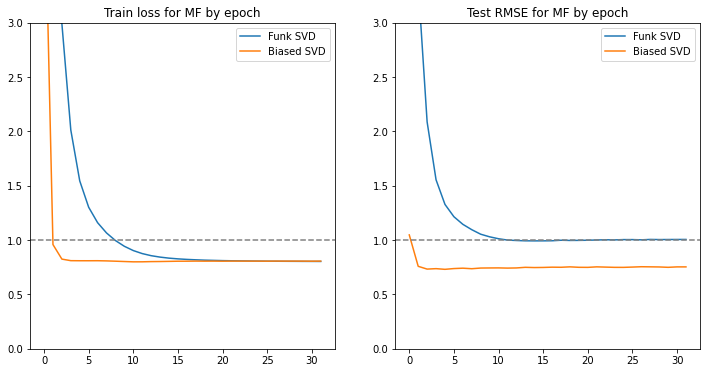

In [77]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Cut your window in 1 row and 2 columns, and start a plot in the first part
plt.subplot(121)
plt.plot(list(range(N_EPOCHS)), fsvd_train_loss_by_ep)
plt.plot(list(range(N_EPOCHS)), bsvd_train_loss_by_ep)
plt.axhline(y=1, color='grey', linestyle='--')
plt.legend(['Funk SVD', 'Biased SVD'])
plt.title("Train loss for MF by epoch")
plt.ylim([0,3])

# And now add something in the second part:
plt.subplot(122)
plt.plot(list(range(N_EPOCHS)), fsvd_test_rmse_by_ep)
plt.plot(list(range(N_EPOCHS)), bsvd_test_rmse_by_ep) 
plt.axhline(y=1, color='grey', linestyle='--')
plt.legend(['Funk SVD', 'Biased SVD'])
plt.title("Test RMSE for MF by epoch")
plt.ylim([0,3])

# Show the graph
plt.show()